In [1]:
import numpy as np
from scipy.sparse.linalg import expm_multiply, expm
import matplotlib.pyplot as plt
from qiskit.synthesis import SuzukiTrotter
from scipy.optimize import minimize, linprog
from scipy.linalg import eigh, eig
import random
import cmath

In [203]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.eye(2)

n = 3

# coeffs = [1,2,3]
# Us = [np.kron(X, X), np.kron(Y,Y), np.kron(Z,Z)]  # 2 qubit Hamiltonian terms

coeffs = [1,2,3,1,2,3]
Us = [np.kron(np.kron(X, X), I), np.kron(np.kron(Y, Y), I), np.kron(np.kron(Z, Z), I), np.kron(I, np.kron(X, X)), np.kron(I, np.kron(Y, Y)), np.kron(I, np.kron(Z, Z))]   # 3 qubit Hamiltonian terms

# coeffs = [1,1]
# Us = [np.kron(np.kron(Z,X), np.kron(Z,I)), np.kron(np.kron(I,Z), np.kron(X,Z))]

# coeffs = [1,1,1]
# Us = [np.kron(np.kron(Z,X), np.kron(Z,np.kron(I,I))), np.kron(np.kron(I,Z), np.kron(X,np.kron(Z,I))), np.kron(np.kron(np.kron(I,I),Z), np.kron(X,Z))]

H = sum([b*U for b, U in zip(coeffs, Us)])
# H1 /= np.linalg.norm(H1, 2)

In [204]:
def compute_Hkl(ref_states, Ham):
    dim = len(ref_states)
    Hkl = np.zeros((dim, dim), dtype=np.complex64)

    for i in range(dim):
        for j in range(dim):
            Hkl[i][j] = (np.conj(ref_states[i]) @ Ham @ ref_states[j]) # shouldn't be an imaginary part
    return Hkl

def compute_S(ref_states):
    dim = len(ref_states)
    S = np.zeros((dim, dim), dtype=np.complex64)

    for i in range(dim):
        for j in range(dim):
            S[i][j] = (np.conj(ref_states[i]) @ ref_states[j])
    return S

def random_initial_state(n):
    components = [complex(random.uniform(-1, 1), random.uniform(-1, 1)) for _ in range(n)]
    magnitude = cmath.sqrt(sum(comp.real**2 + comp.imag**2 for comp in components))
    normalized_vector = [comp / magnitude for comp in components]
    
    return np.array(normalized_vector)

In [205]:
tf = 10
ts = np.linspace(0, tf, 200)

init = random_initial_state(2**n)
ref_states = [init]
M = 6
tau = 0.1

for i in range(1, M):
    ref_states.append(expm_multiply(-1j * tau * i * H, init))

In [206]:
Hkl = compute_Hkl(ref_states, H)
S = compute_S(ref_states)
print(np.round(S, 2))

U, D, Vh = np.linalg.svd(S)
print(D)
eps = 1e-5
D[np.abs(D) < eps] = 0
D_inv = [1/d if d > 0 else 0 for d in D]
S_inv = Vh.conj().T @ np.diag(D_inv) @ U.conj().T

# c0 = np.linalg.inv(S) @ S[:,0]
c0 = np.zeros(len(ref_states))
c0[0] = 1
# c0

[[ 1.  +0.j    0.83+0.06j  0.4 +0.02j -0.05-0.14j -0.28-0.34j -0.2 -0.44j]
 [ 0.83-0.06j  1.  +0.j    0.83+0.06j  0.4 +0.02j -0.05-0.14j -0.28-0.34j]
 [ 0.4 -0.02j  0.83-0.06j  1.  +0.j    0.83+0.06j  0.4 +0.02j -0.05-0.14j]
 [-0.05+0.14j  0.4 -0.02j  0.83-0.06j  1.  +0.j    0.83+0.06j  0.4 +0.02j]
 [-0.28+0.34j -0.05+0.14j  0.4 -0.02j  0.83-0.06j  1.  +0.j    0.83+0.06j]
 [-0.2 +0.44j -0.28+0.34j -0.05+0.14j  0.4 -0.02j  0.83-0.06j  1.  +0.j  ]]
[3.1068850e+00 2.3687801e+00 5.2231413e-01 2.0204692e-03 5.1698244e-08
 1.5186831e-08]


In [207]:
def QKFFEvolve(t, init):
    ct = expm(-1j * t * S_inv @ Hkl) @ init
    return sum([ct[i] * ref_states[i] for i in range(len(ct))])

exact_te = [expm_multiply(-1j * H * t, init) for t in ts]
qkff_te = [QKFFEvolve(t, c0) for t in ts]

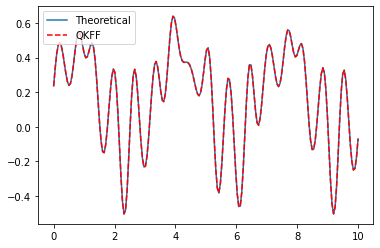

In [209]:
# O = np.kron(np.kron(np.kron(I,I),Z), np.kron(I,I))
O = np.kron(Z,I)
O = np.kron(Z, np.kron(I,I))

exact_Z1 = [(np.conj(psi) @ O @ psi).real for psi in exact_te]
qkff_Z1 = [(np.conj(psi) @ O @ psi).real for psi in qkff_te]

exact_auto = [(np.conj(init) @ psi).real for psi in exact_te]
qkff_auto = [(np.conj(init) @ psi).real for psi in qkff_te]


plt.plot(ts, exact_Z1, label="Theoretical")
plt.plot(ts, qkff_Z1, "r--", label="QKFF")

# plt.plot(ts, exact_auto, label="Exact auto")
# plt.plot(ts, qkff_auto, label="QKFF auto")

# plt.plot(ts, qkff_Z1, 'r--', label="QKFF, R=1, M=6")
plt.legend(loc='upper left')